In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, MessagePassing

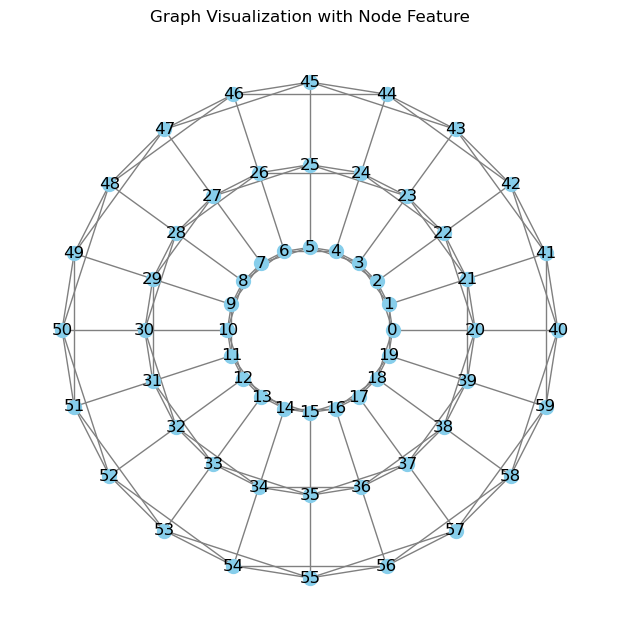

In [2]:
# Function to generate a concentric graph
def generate_concentric_graphs(layers, nodes_per_layer, k):
    G = nx.Graph()

    # Create nodes for each layer
    total_nodes = layers * nodes_per_layer
    for layer in range(layers):
        # Define the radius of the current layer
        radius = layer + 1
        # Calculate the angle between each point (in radians)
        angle_gap = 2 * np.pi / nodes_per_layer

        for i in range(nodes_per_layer):
            angle = i * angle_gap
            x, y = radius * np.cos(angle), radius * np.sin(angle)
            node_id = layer * nodes_per_layer + i
            G.add_node(node_id, pos=(x, y))

            # Connect each node to its k-hop neighbors in the same layer
            for hop in range(1, k + 1):
                neighbor_index = (i + hop) % nodes_per_layer
                G.add_edge(node_id, layer * nodes_per_layer + neighbor_index)
                neighbor_index = (i - hop) % nodes_per_layer
                G.add_edge(node_id, layer * nodes_per_layer + neighbor_index)

    # Connect nodes between layers
    for layer in range(1, layers):
        for i in range(nodes_per_layer):
            this_layer_node = layer * nodes_per_layer + i
            inner_layer_node = (layer - 1) * nodes_per_layer + i
            G.add_edge(this_layer_node, inner_layer_node)

    # Get positions for visualization
    pos = nx.get_node_attributes(G, 'pos')
    return G, pos

# Paramaters for k_model graph
layers = 3
nodes_per_layer = 20
k_model = 2

# Generate the graph
G, pos = generate_concentric_graphs(layers, nodes_per_layer, k_model)

# Convert networkx graph to PyTorch Geometric Data
data = pyg_utils.from_networkx(G)

# Plot the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=100, node_color="skyblue", edge_color="gray")
plt.title("Graph Visualization with Node Feature")
plt.show()

In [3]:
# Parameters for the time series
frequency = 1
time_steps = 200
influence_strength = 0.5

# Function to generate random time series (sine waves)
def generate_initial_time_series(num_nodes, frequency, time_steps, i):
    np.random.seed(i)
    initial_time_series = np.zeros((num_nodes, time_steps))

    for i in range(num_nodes):
        random_start = np.random.rand() * 2 * np.pi  # Generate a random starting point
        t = np.linspace(random_start, random_start + 4 * np.pi, time_steps)
        
        # Generate Gaussian noise
        # noise = np.random.normal(0, 0.1, time_steps)
        
        initial_time_series[i, :] = np.sin(frequency * t) #+ noise

    return initial_time_series

# Function to adjust the time series based on k-hop neighbors
def adjust_time_series_for_neighbors(G, time_series, influence_strength):
    adjusted_time_series = time_series.copy()
    for node in G.nodes():
        neighbors = list(nx.single_source_shortest_path_length(G, node, cutoff=1).keys())
        neighbors.remove(node)  # exclude the node itself
        for neighbor in neighbors:
            adjusted_time_series[node] += influence_strength * time_series[neighbor]
    
    return adjusted_time_series

# Function to normalize the adjusted time series
def normalize_time_series(time_series):
    num_nodes = time_series.shape[0] 
    normalized_time_series = np.zeros(time_series.shape)
    
    for i in range(num_nodes):
        # Calculate the min and max across all nodes and time steps
        min_val = np.min(time_series[i])
        max_val = np.max(time_series[i])
    
        # Normalize the time series to the range [-1, 1]
        normalized_time_series[i] = 2 * ((time_series[i] - min_val) / (max_val - min_val)) - 1
    
    return normalized_time_series

# Generate initial time series
initial_time_series = generate_initial_time_series(G.number_of_nodes(), frequency, time_steps, 0)

# Generate k_data graph and adjust the time series based on the k-hop neighbors (k_data)
k_data = 2
G_data, pos_data = generate_concentric_graphs(layers, nodes_per_layer, k_data)

adjusted_time_series = adjust_time_series_for_neighbors(G_data, initial_time_series, influence_strength)
normalized_adjusted_time_series = normalize_time_series(adjusted_time_series)

torch.Size([95, 60, 5]) torch.Size([95, 60, 1])


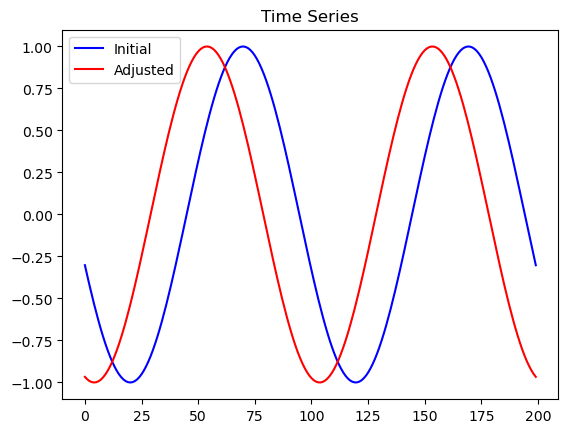

In [4]:
# Define the number of previous time step used to predict next time step
previous_step = 5

# Add time series to Data
data.y = torch.tensor(normalized_adjusted_time_series[:, 0:100], dtype=torch.float)
data.input = []
data.output = []
for i in range(100 - previous_step):
    data.input.append(data.y[:, i:i+previous_step])
    data.output.append(data.y[:, i+previous_step:i+previous_step+1])
data.input = torch.stack(data.input)
data.output = torch.stack(data.output)
print(data.input.shape, data.output.shape)

plt.plot(initial_time_series[0], 'b', label = 'Initial')
plt.plot(normalized_adjusted_time_series[0], 'r', label = 'Adjusted')
plt.title("Time Series")
plt.legend()

In [5]:
class GNNModel(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channel, k_data):
        super(GNNModel, self).__init__(aggr='add')
        
        # Initialize the 2 GCNConv layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Linear layer for forecasting the next time step value
        self.linear = nn.Linear(hidden_channels, out_channel)
        
    def forward(self, y, edge_index):  
        # Pass through the 2 GCNConv layers with a non-linear layer after each linear layer
        # Used tanh as its range is from -1 to 1 which is the same as range of sin function
        x = torch.tanh(self.conv1(y, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))
        
        # Forecast the next time step value and normalize output to [-1, 1]
        x = torch.tanh(self.linear(x))

        return x
    
# Parameters for the GNN Model
hidden_channels = 64
out_channel = 1

# Generate the models and predictions
model = GNNModel(previous_step, hidden_channels, out_channel, k_data)

In [6]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 100

# Training loop with teacher forcing
model.train()
    
for epoch in range(num_epochs): 
    node_loss = np.zeros(data.num_nodes)
    
    optimizer.zero_grad()

    # Forward pass
    output = model(data.input, data.edge_index)

    # Calculate loss
    target = data.output
    loss = criterion(output, target)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
        
    print(f'Epoch: {epoch + 1}, Average Loss: {loss.item()}')

Epoch: 1, Average Loss: 0.3377295732498169
Epoch: 2, Average Loss: 0.31606611609458923
Epoch: 3, Average Loss: 0.297047883272171
Epoch: 4, Average Loss: 0.28067806363105774
Epoch: 5, Average Loss: 0.2669026553630829
Epoch: 6, Average Loss: 0.2556052505970001
Epoch: 7, Average Loss: 0.24661339819431305
Epoch: 8, Average Loss: 0.23970505595207214
Epoch: 9, Average Loss: 0.23461930453777313
Epoch: 10, Average Loss: 0.2310735136270523
Epoch: 11, Average Loss: 0.22878332436084747
Epoch: 12, Average Loss: 0.22748057544231415
Epoch: 13, Average Loss: 0.22692331671714783
Epoch: 14, Average Loss: 0.22689960896968842
Epoch: 15, Average Loss: 0.22722840309143066
Epoch: 16, Average Loss: 0.2277594357728958
Epoch: 17, Average Loss: 0.22837264835834503
Epoch: 18, Average Loss: 0.22897633910179138
Epoch: 19, Average Loss: 0.22950486838817596
Epoch: 20, Average Loss: 0.22991497814655304
Epoch: 21, Average Loss: 0.2301820069551468
Epoch: 22, Average Loss: 0.23029594123363495
Epoch: 23, Average Loss: 0.

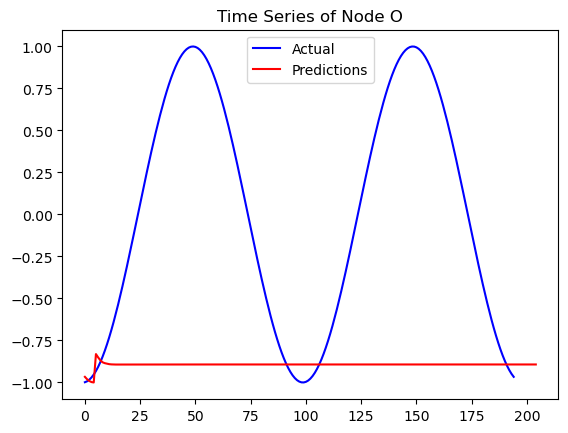

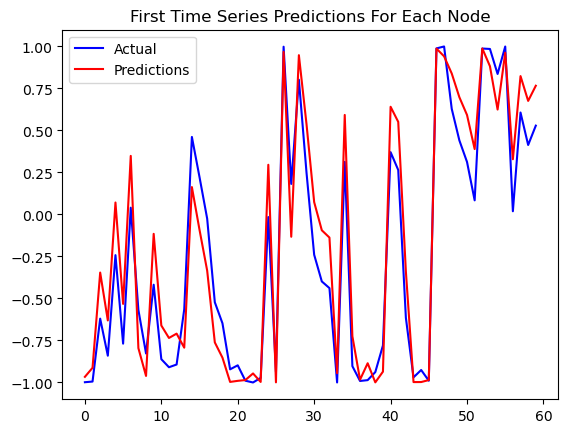

In [7]:
def predictions(model, data, num_time_steps):
    # Initialize the predictions tensor
    num_nodes = data.num_nodes
    predictions = data.y[:, 0:previous_step].unsqueeze(0)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for t in range(num_time_steps):
            # Predict the next time step value
            predicted_next_values = model(predictions[:, :, -previous_step:], data.edge_index)
            predictions = torch.cat([predictions, predicted_next_values], dim=-1)          
    return predictions

# Perform the auto-regressive prediction
predictions_values = predictions(model, data, time_steps)

# Plot Time Series of Node O
plt.plot(normalized_adjusted_time_series[0, previous_step:], 'b', label = 'Actual')
plt.plot(predictions_values[0, 0, :], 'r', label = 'Predictions')
plt.title("Time Series of Node O")
plt.legend()

# Plot First Time Series Predictions For Each Node
plt.figure()
plt.plot(normalized_adjusted_time_series[:, previous_step], 'b', label = 'Actual')
plt.plot(predictions_values[0, :, 0], 'r', label = 'Predictions')
plt.title("First Time Series Predictions For Each Node")
plt.legend()